<a href="https://colab.research.google.com/github/yjchen9596/tensorflow-for-deep-learning/blob/main/l08c06_forecasting_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [37]:
# Re-run this cell and all subsequent cells
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    # Explicitly import tf within the function to ensure its availability
    # This import was already present, but re-running the setup should ensure
    # tf is globally available before model loading.
    import tensorflow as tf
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

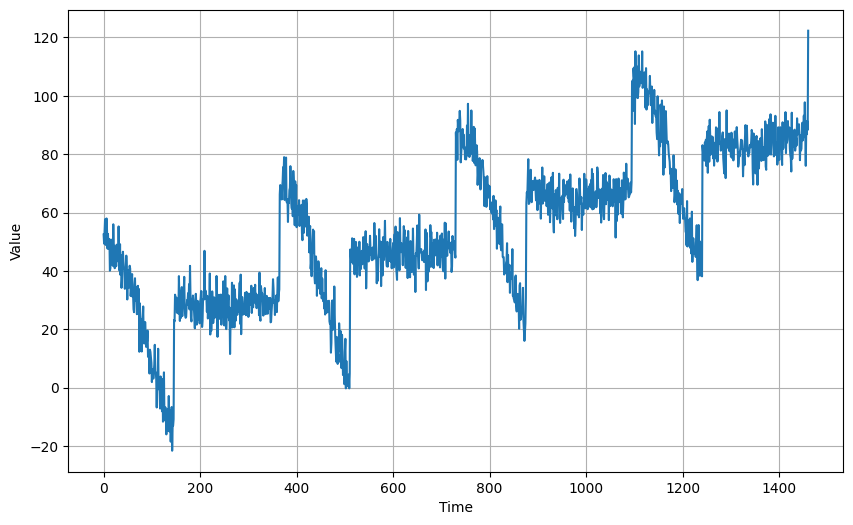

In [30]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [31]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30 #30days
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), #use lambda to expand the input batchs to add the dimension the size is 1.
                      input_shape=[None]), #any length
  keras.layers.SimpleRNN(100, return_sequences=True), # 100 units/neurons
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # do this because the input is not scaled at all and they are fairly large, by multiplying 200, we let the model to use fiarly small weights and yet produce fairly large outputs. this helps stablize the network
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 70.0042 - mae: 70.5042 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 37.4349 - mae: 37.9315 - learning_rate: 1.1220e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 26.2093 - mae: 26.7052 - learning_rate: 1.2589e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 21.9783 - mae: 22.4737 - learning_rate: 1.4125e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 20.4903 - mae: 20.9823 - learning_rate: 1.5849e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 17.5107 - mae: 18.0023 - learning_rate: 1.7783e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 17.7121 - mae: 18.2059 - learning_rate: 1.9953e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 16.6133 - mae: 17.1029 - learning_rate: 2.2387e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 17.0369 - mae: 17.5282 - learning_rate: 2.5119e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 14.6792 - mae: 15.1661 - learning_rate: 2.8184e-07
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

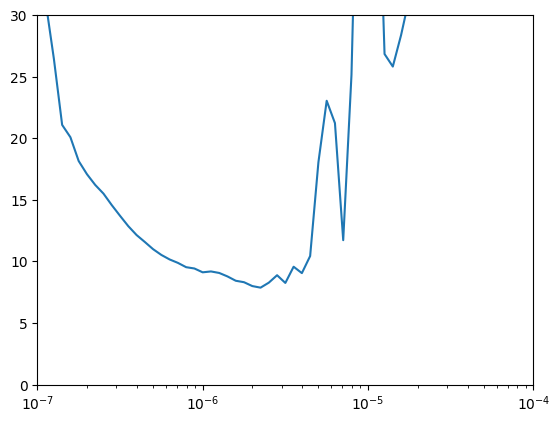

In [33]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Reshape

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    Reshape((-1, 1), input_shape=[None]),   # exactly the same as expand_dims
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)  # you could also replace this with a Mul layer
])
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(  # use model check point callback to save the model everytime its improves its validation set
    "my_checkpoint.keras", save_best_only=True) # Added .keras extension
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint]) # early check points, the model will automatially stops at 50

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 35ms/step - loss: 23.0269 - mae: 23.5220

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 22.5660 - mae: 23.0605 - val_loss: 15.0909 - val_mae: 15.5872
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 14.5617 - mae: 15.0516 - val_loss: 5.8472 - val_mae: 6.3312
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 11.6096 - mae: 12.0959 - val_loss: 12.2056 - val_mae: 12.7028
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 10.6311 - mae: 11.1201 - val_loss: 5.9003 - val_mae: 6.3810
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.1038 - mae: 9.5903 - val_loss: 7.1369 - val_mae: 7.6225
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.4768 - mae: 9.9594 - val_loss: 5.9912 - val_mae: 6.4807
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 9.7151 - mae: 10.1946 - val_loss: 8.2820 - val_mae: 8.7716
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 9.6812 - mae: 10.1668 - val_loss: 4.7921 - val_mae: 5.2716
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 8.5003 - 

In [57]:
import tensorflow as tf

# Ensure tf is imported and available before loading the model
# The original code already does this, but it's good practice to reiterate
# or ensure the import happens in the same cell where the model is loaded.
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False, custom_objects={'tf': tf})

In [58]:
import tensorflow as tf
from tensorflow import keras

rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size
)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


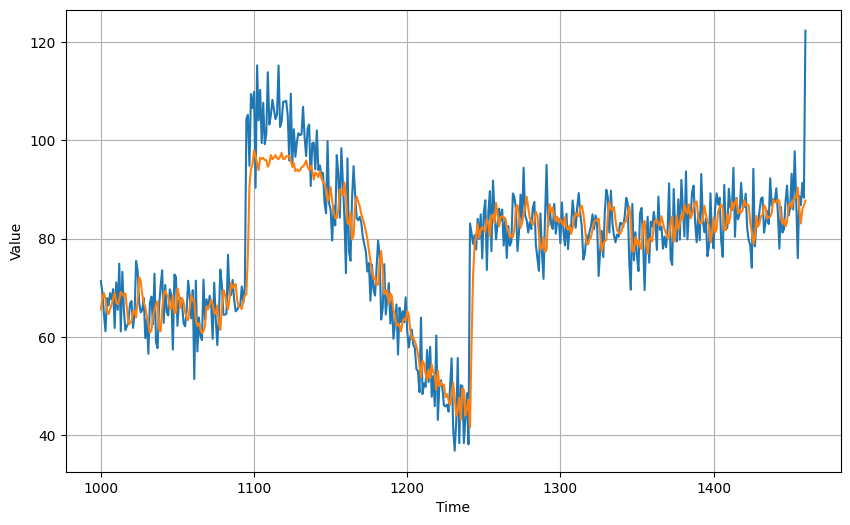

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [64]:
from tensorflow.keras.metrics import MeanAbsoluteError

mae_metric = MeanAbsoluteError()
mae_metric.update_state(x_valid, rnn_forecast)
print("MAE:", mae_metric.result().numpy())

MAE: 5.1499543


## Sequence-to-Sequence Forecasting

In [65]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [66]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [68]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 74.9106 - mae: 75.4095 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 50.4039 - mae: 50.9014 - learning_rate: 1.0798e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 41.9939 - mae: 42.4911 - learning_rate: 1.1659e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 40.7448 - mae: 41.2414 - learning_rate: 1.2589e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 33.4371 - mae: 33.9325 - learning_rate: 1.3594e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 29.9119 - mae: 30.4053 - learning_rate: 1.4678e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 24.8492 - mae: 25.3410 - learning_rate: 1.5849e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 22.8910 - mae: 23.3808 - learning_rate: 1.7113e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.7397 - mae: 22.2292 - learning_rate: 1.8478e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 20.9772 - mae: 21.4669 - learning_rate: 1.9953e-07
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

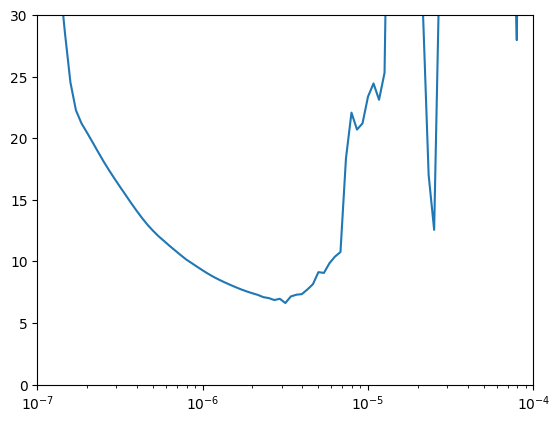

In [70]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 63ms/step - loss: 253.3408 - mae: 253.8408

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 239.2033 - mae: 239.7031 - val_loss: 22.2209 - val_mae: 22.7170
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 72.7938 - mae: 73.2931 - val_loss: 17.0197 - val_mae: 17.5111
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 38.1941 - mae: 38.6926 - val_loss: 44.3648 - val_mae: 44.8648
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 26.7448 - mae: 27.2418 - val_loss: 32.9396 - val_mae: 33.4394
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 20.7958 - mae: 21.2911 - val_loss: 13.7728 - val_mae: 14.2681
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 16.7498 - mae: 17.2422 - val_loss: 14.7181 - val_mae: 15.2109
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 13.2079 - mae: 13.6986 - val_loss: 13.9183 - val_mae: 14.4113
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 12.2085 - mae: 12.6967 - val_loss: 12.5298 - val_mae: 13.0221
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/s

In [73]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


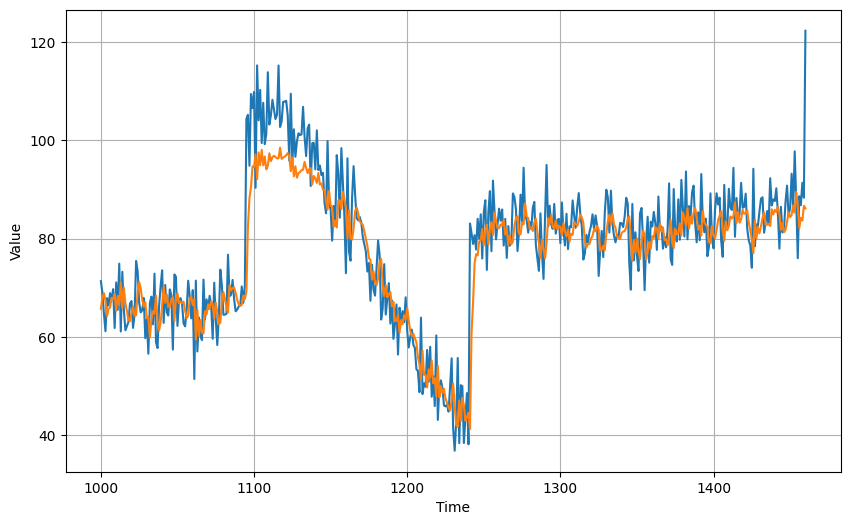

In [74]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [76]:
from tensorflow.keras.metrics import MeanAbsoluteError

# Instantiate the metric
mae_metric = MeanAbsoluteError()

# Update the state with the true values and the forecast
mae_metric.update_state(x_valid, rnn_forecast)

# Get the final MAE value
print("MAE:", mae_metric.result().numpy())

MAE: 5.2407947
